In [40]:
import torch
import torchvision
from torch.nn import functional as F
import torch.nn as nn
from env import Name, MazeEnv
from model import LSTM, LSTM_Attn
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
import matplotlib.pyplot as plt
from util import Tester
from torchvision.transforms import Resize
from torchvision.transforms import InterpolationMode
import sklearn
from sklearn.decomposition import PCA
import numpy as np


resnet18 = torchvision.models.resnet18(pretrained=True)
modules = list(resnet18.children())[:5]
img_encoder = nn.Sequential(*modules)
img_encoder.eval()
for p in img_encoder.parameters():
    p.requires_grad = False


# PCA Analysis

## Utility functions

In [84]:
map_act = {0: 'down', 1: 'up', 2: 'right', 3: 'left'}
pca = PCA(n_components = 2)
# given specific task, return hs and action seq
def analysis(task, limit=5):
    agent = LSTM_Attn(hidden_size=256, channel_size=64)
    path = 'checkpoint/rnn_20000'
    agent.load_state_dict(torch.load(path))
    agent.eval()

    hs = []
    acts = []
    mem_state = agent.get_init_states()
    p_action = torch.zeros([1, 1, 4])
    for _ in range(limit):
        img = task.transform(task.img()).unsqueeze(0)
        img = img_encoder(img)
        logit, mem_state = agent(img, p_action, mem_state)  
        logit = logit.flatten()
        action = logit.argmax().item()
        acts.append(action)
        hs.append(mem_state[0].flatten().detach().numpy())
        reward = task.step(action)
        if reward == 0:
            break
        p_action = torch.eye(4)[action].view(1, 1, -1)
    hs = np.stack(hs)
    task.reset()
    
    return reward, acts, hs

## Maze without walls

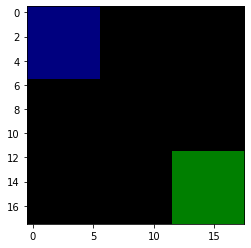

In [106]:
task = MazeEnv(length=3, resize=18)
state = torch.ones(3, 3)
state[0,0] = Name.current
state[2,2] = Name.goal
task.set_state(state)
img = task.transform(task.img())
plt.imshow(img.permute(1, 2, 0))
plt.savefig('maze_wo_wall')

Succeed
Actions: down->down->right->right


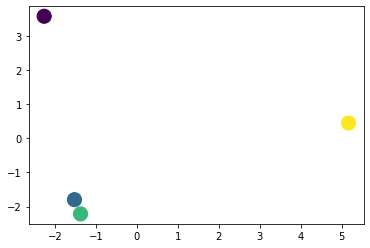

In [107]:
reward, acts, hs = analysis(task)
print('Succeed' if reward == 0 else 'Failed')
act_seq = '->'.join([map_act[i] for i in acts])
print('Actions: ' + act_seq)

pca.fit(hs)
x = pca.transform(hs)
idx = list(range(len(hs)))
plt.scatter(x[:, 0], x[:, 1], c=idx, cmap='viridis', s=200)
plt.savefig('pca_wo_wall')

## Maze with walls

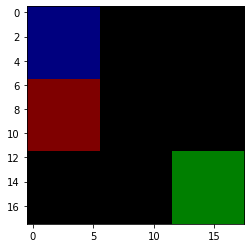

In [109]:
task = MazeEnv(length=3, resize=18)
state = torch.ones(3, 3)
state[0,0] = Name.current
state[2,2] = Name.goal
state[1,0] = Name.wall
#state[1,1] = Name.wall
task.set_state(state)
img = task.transform(task.img())
plt.imshow(img.permute(1, 2, 0))
plt.savefig('maze_w_wall')

Succeed
Actions: right->down->down->right


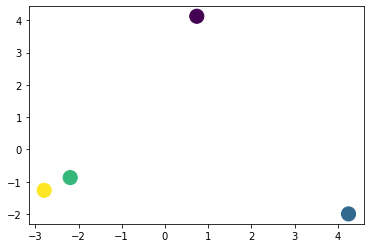

In [110]:
reward, acts, hs = analysis(task)
print('Succeed' if reward == 0 else 'Failed')
act_seq = '->'.join([map_act[i] for i in acts])
print('Actions: ' + act_seq)

pca.fit(hs)
x = pca.transform(hs)
idx = list(range(len(hs)))
plt.scatter(x[:, 0], x[:, 1], c=idx, cmap='viridis', s=200)
plt.savefig('pca_w_wall')

## Blocked Maze

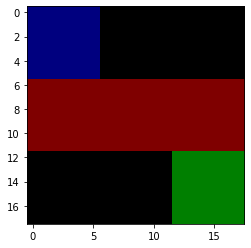

In [111]:
task = MazeEnv(length=3, resize=18)
state = torch.ones(3, 3)
state[0,0] = Name.current
state[2,2] = Name.goal
state[1,0] = Name.wall
state[1,1] = Name.wall
state[1,2] = Name.wall
task.set_state(state)
img = task.transform(task.img())
plt.imshow(img.permute(1, 2, 0))
plt.savefig('maze_blocked')

Failed
Actions: right->right->right->right->right->right


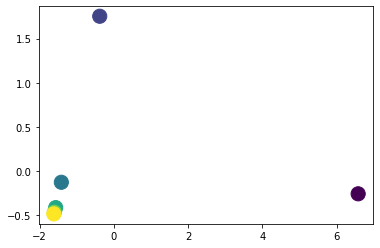

In [112]:
reward, acts, hs = analysis(task, limit=6)
print('Succeed' if reward == 0 else 'Failed')
act_seq = '->'.join([map_act[i] for i in acts])
print('Actions: ' + act_seq)

pca.fit(hs)
x = pca.transform(hs)
idx = list(range(len(hs)))
plt.scatter(x[:, 0], x[:, 1], c=idx, cmap='viridis', s=200)
plt.savefig('pca_blocked')